<a href="https://colab.research.google.com/github/krishnarevi/Attention_model_from_scratch/blob/main/Prediction_of_bad_deliveries.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
import numpy as np
import statistics
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime, timedelta
from math import sqrt

from sklearn.model_selection  import train_test_split
from sklearn.model_selection import cross_val_score, KFold, GridSearchCV
from sklearn import metrics
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn import tree
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.metrics import accuracy_score, r2_score,mean_squared_error
from sklearn.metrics import confusion_matrix, classification_report
#import graphviz

%matplotlib inline
import matplotlib as mp
import matplotlib.pyplot as plt
 
import scipy.stats as scs
import scipy.stats as stats

import statsmodels.api as sm
from datetime import date, datetime, time
import os
import json
import seaborn as sns
import catboost as cat
from sklearn.linear_model import LassoLars
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import time
sns.set(style='whitegrid')

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
# mount g-drive to access datafiles
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# setting path
path= '/content/drive/MyDrive/data/location_task'
os.chdir(path)
print("current dir is: %s" % (path))

current dir is: /content/drive/MyDrive/data/location_task


In [5]:

# reading data files
with open("location_task_no_nulls.json", "r") as read_file:
    data = json.load(read_file)

In [6]:
df = pd.DataFrame(data)
df.head()

,order_id,order_value,order_items_count,customer_id,created_timestamp_local,has_instruction,logistics_dropoff_distance,delivery_postal_code,delivery_geohash_precision8,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction
618,b8ds-tqhf,40.440,10,h6huq0td,2021-03-11T20:19:50,True,58.656,828868,w23bh248,False,False,False,False,False,False,False,False
619,x5xx-j2d2,35.600,10,t2nod4rq,2021-03-12T18:42:48,True,39.025,530548,w21zu55k,False,False,False,False,False,False,False,False
620,x6qu-14kt,42.490,12,m4ycd3tm,2021-03-27T11:29:17,True,40.068,650248,w21z9jc4,False,False,True,False,False,False,False,False
621,x3yw-rhc5,14.400,11,sgmnf9sb,2021-03-02T22:08:52,True,44.987,550105,w21zg97y,False,False,False,False,False,False,False,False
622,y9zp-58q7,38.150,10,x4rvv3iy,2021-03-23T20:35:26,True,71.521,102112,w21z61q6,False,False,False,False,False,False,False,False


## Exploratory Data Analysis (EDA) & Feature Engineering

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2593799 entries, 618 to 2964438
Data columns (total 17 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   order_id                     object 
 1   order_value                  float64
 2   order_items_count            int64  
 3   customer_id                  object 
 4   created_timestamp_local      object 
 5   has_instruction              bool   
 6   logistics_dropoff_distance   float64
 7   delivery_postal_code         object 
 8   delivery_geohash_precision8  object 
 9   has_phone_number             bool   
 10  has_call_instruction         bool   
 11  has_leave_instruction        bool   
 12  has_lift_instruction         bool   
 13  has_lobby_instruction        bool   
 14  has_gate_instruction         bool   
 15  has_knock_instruction        bool   
 16  has_bell_instruction         bool   
dtypes: bool(9), float64(2), int64(1), object(5)
memory usage: 200.4+ MB


In [8]:
print("shape of df is {} ".format(df.shape))

shape of df is (2593799, 17) 


In [9]:
#convert two float columns(order_value and logistics_dropoff_distance ) into int ,this will save space , also doesn't affect model performance much
df['logistics_dropoff_distance'] = np.floor(pd.to_numeric(df['logistics_dropoff_distance'], errors='coerce')).astype('Int64')
df['order_value'] = np.floor(pd.to_numeric(df['order_value'], errors='coerce')).astype('Int64')

In [10]:
#Checking for null values 
print(df.isna().sum())

order_id                       0
order_value                    0
order_items_count              0
customer_id                    0
created_timestamp_local        0
has_instruction                0
logistics_dropoff_distance     0
delivery_postal_code           0
delivery_geohash_precision8    0
has_phone_number               0
has_call_instruction           0
has_leave_instruction          0
has_lift_instruction           0
has_lobby_instruction          0
has_gate_instruction           0
has_knock_instruction          0
has_bell_instruction           0
dtype: int64


In [11]:
df.describe()

,order_value,order_items_count,logistics_dropoff_distance
count,2593799.000,2593799.000,2593799.000
mean,20.631,2.607,93.040
std,16.008,1.975,16524.893
min,0.000,1.000,0.000
25%,11.000,1.000,21.000
50%,16.000,2.000,37.000
75%,25.000,3.000,63.000
max,872.000,61.000,15328253.000


In [12]:
df.nunique()

order_id                       2593799
order_value                        413
order_items_count                   53
customer_id                     565549
created_timestamp_local        1376285
has_instruction                      2
logistics_dropoff_distance        5854
delivery_postal_code             47891
delivery_geohash_precision8     119673
has_phone_number                     2
has_call_instruction                 2
has_leave_instruction                2
has_lift_instruction                 2
has_lobby_instruction                2
has_gate_instruction                 2
has_knock_instruction                2
has_bell_instruction                 2
dtype: int64

###EDA on logistics_dropoff_distance

In [13]:
#dividing relevance scores into two categories for easier analysis if logistics_dropoff_distance > 10km(10000 mtrs) we say distance is "huge", between 1000 and 10000 "large" otherwise "small"
df['class'] = df['logistics_dropoff_distance'].apply(lambda x: 'small' if x<1000.0 else ('large' if x<10000 else "huge"))
# lambda x : x*2 if x < 10 else (x*3 if x < 20 else x)

In [14]:
df['class'].value_counts()

small    2576369
large      16489
huge         941
Name: class, dtype: int64

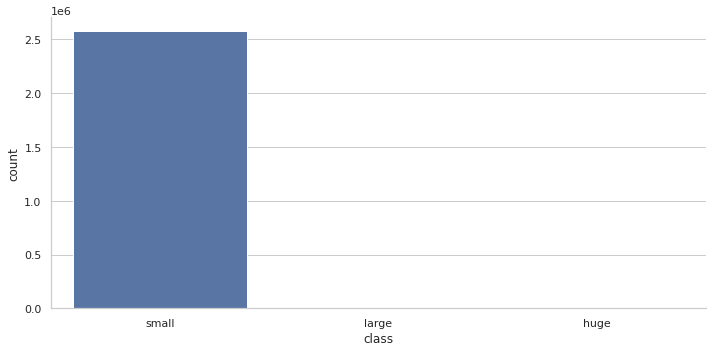

In [15]:
sns.catplot(x='class', kind='count', data=df, height=5, aspect=2)
plt.show()



*   There is a significant class imbalance here
*   Orders where logistics_dropoff_distance is greater than 10 km is just 0.03% of total orders
*   Orders where logistics_dropoff_distance is greater than 1 km but less than 10 km is around 0.6% of total orders






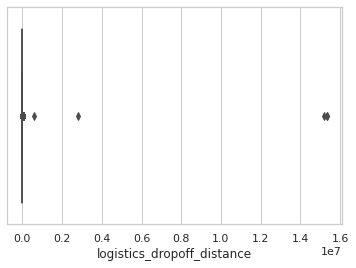

In [16]:
sns.boxplot(df['logistics_dropoff_distance'])

There are some outliers present in data , having a logistics dropoff distance greater than 10km is unusual 

In [17]:
# # remove outliers from data based on target column 
# def remove_outlier(df_in, col_name):
#     q1 = df_in[col_name].quantile(0.25)
#     q3 = df_in[col_name].quantile(0.75)
#     iqr = q3-q1 #Interquartile range
#     fence_low  = q1-1.5*iqr
#     fence_high = q3+1.5*iqr
#     df_out = df_in.loc[(df_in[col_name] > fence_low) & (df_in[col_name] < fence_high)]
#     return df_out

###Removing outliers

In [18]:
#remove outliers with quantile filter

q_hi  = df["logistics_dropoff_distance"].quantile(0.995) # remove top .005 quantile

cleaned_df = df[df["logistics_dropoff_distance"] < q_hi]

In [19]:
cleaned_df.describe()

,order_value,order_items_count,logistics_dropoff_distance
count,2580826.000,2580826.000,2580826.000
mean,20.619,2.607,56.952
std,15.981,1.974,88.653
min,0.000,1.000,0.000
25%,11.000,1.000,21.000
50%,16.000,2.000,37.000
75%,25.000,3.000,63.000
max,872.000,61.000,1274.000




*   Now the maximum value in logistics_dropoff_distance is 1274m (~ 1km) which does not seem unusual for dropoff distance




In [20]:
cleaned_df.columns

Index(['order_id', 'order_value', 'order_items_count', 'customer_id',
       'created_timestamp_local', 'has_instruction',
       'logistics_dropoff_distance', 'delivery_postal_code',
       'delivery_geohash_precision8', 'has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'class'],
      dtype='object')

###Removing redundant columns

In [21]:
# The attributes "delivery_postal_code","customer_id"  and "delivery_geohash_precision8"  can be removed
# Since they are not important factor affecting the logistics_dropoff_distance
cleaned_df = cleaned_df[['order_id', 'order_value', 'order_items_count', 'created_timestamp_local', 'has_instruction',
       'logistics_dropoff_distance', 'has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'class']]



###EDA on  numerical features 

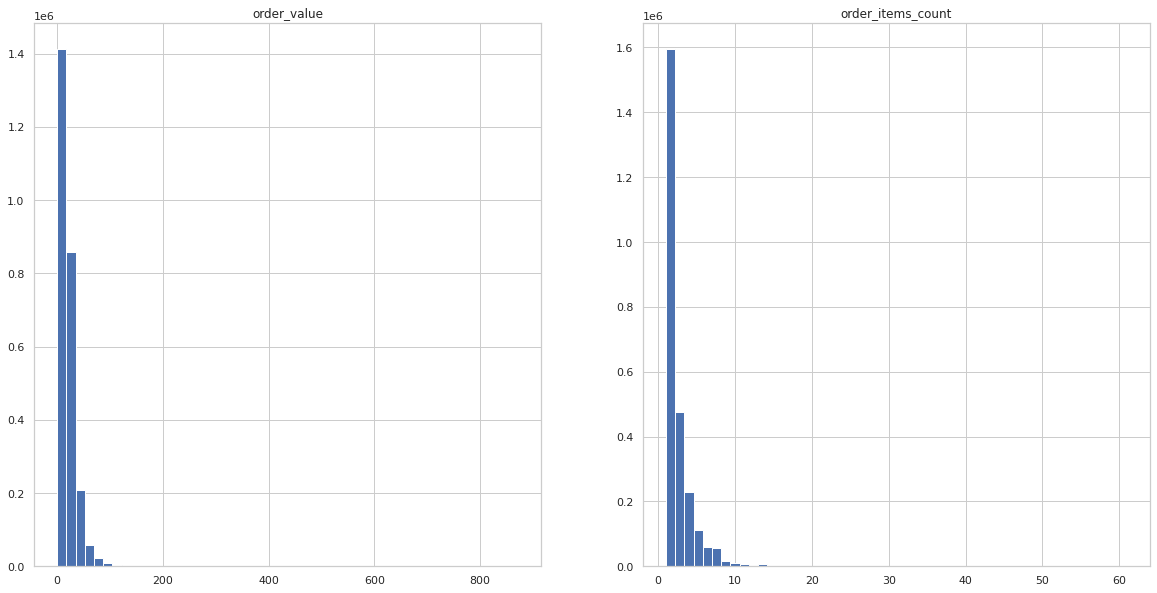

In [22]:
#check Numerical variables distribution
Numerical_column = ['order_value',  'order_items_count']
fig, axes = plt.subplots(1,2, figsize=(20,10))
for i,n in enumerate(Numerical_column):
    axes[i].hist(cleaned_df[n],bins=50)
    axes[i].set_title(n)



*   Most of the times order value is less than 100

*   Most of the times order count is less than 15



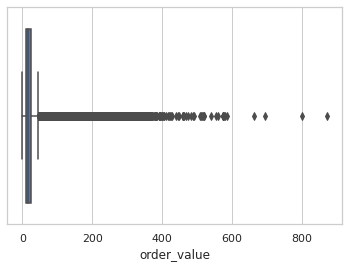

In [23]:
sns.boxplot(cleaned_df['order_value'])

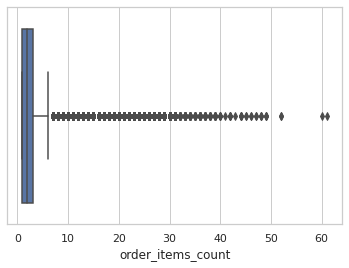

In [24]:
sns.boxplot(cleaned_df['order_items_count'])

###EDA on boolean features

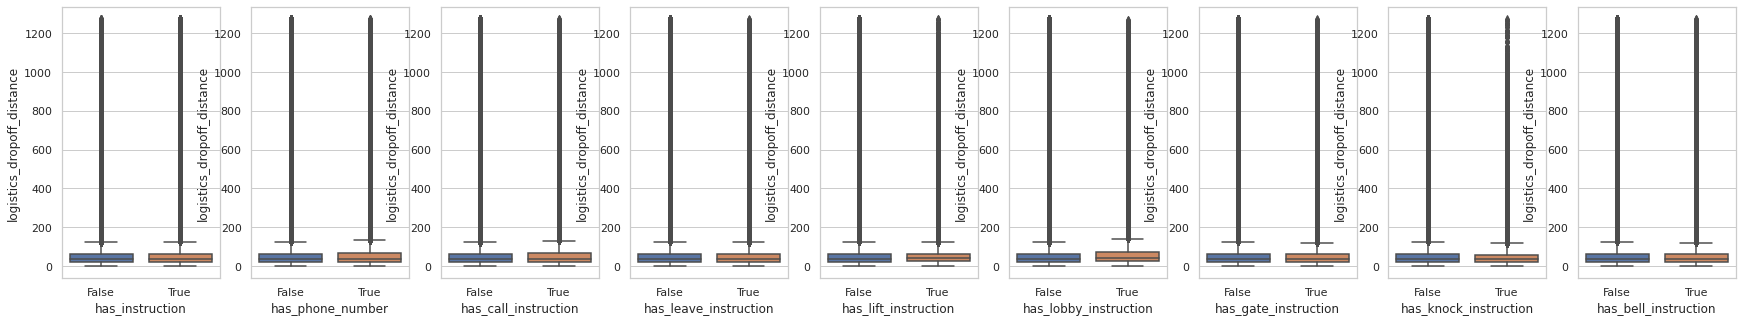

In [25]:
# Proceed to perform EDA on the remaining binary attributes

columns_binary = ['has_instruction','has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction']

fig, ax = plt.subplots(1, 9, figsize=(30, 5))
for i, column in enumerate(columns_binary):
    sns.boxplot(x=column, y='logistics_dropoff_distance', data=cleaned_df, ax=ax[i])
plt.show()

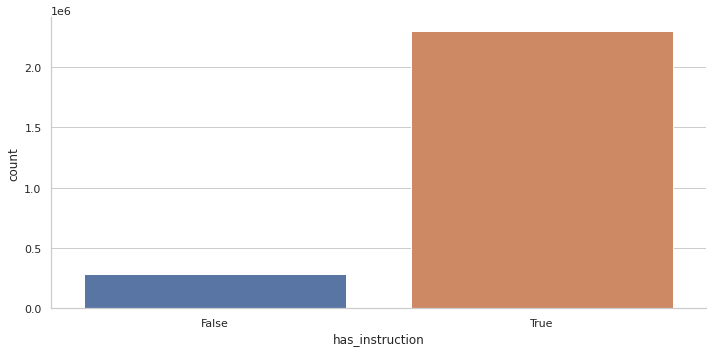

True     2297973
False     282853
Name: has_instruction, dtype: int64

In [26]:
sns.catplot(x='has_instruction', kind='count', data=cleaned_df, height=5, aspect=2)
plt.show()
cleaned_df['has_instruction'].value_counts()

Most of them have delivery instructions

###Feature engineering using the order create date timestamp




From the dataset, there is one datetime attributes available - 'created_timestamp_local'. The attribute 'created_timestamp_local' is important since the schedule of delivery only starts after the order is created. To extract information from the attribute, the feature engineering is performed and the new attributes 'Month', 'Day', 'Day of week' and 'Weekend','Hour' are created as there might be peak period during certain month, day, hour or on weekend.

In [27]:
cleaned_df['created_timestamp_local'] = pd.to_datetime(cleaned_df.created_timestamp_local)

In [28]:
cleaned_df['Month'] = cleaned_df['created_timestamp_local'].apply(lambda x: x.month)
cleaned_df['Day'] = cleaned_df['created_timestamp_local'].apply(lambda x: x.day)
cleaned_df['Hour'] = cleaned_df['created_timestamp_local'].apply(lambda x: x.hour)
cleaned_df['DOW'] = cleaned_df['created_timestamp_local'].dt.dayofweek
cleaned_df['Weekend'] = cleaned_df['created_timestamp_local'].apply(lambda x: 1 if x.weekday() >=5 else 0)

In [29]:
cleaned_df.head()

,order_id,order_value,order_items_count,created_timestamp_local,has_instruction,logistics_dropoff_distance,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,class,Month,Day,Hour,DOW,Weekend
618,b8ds-tqhf,40,10,2021-03-11 20:19:50,True,58,False,False,False,False,False,False,False,False,small,3,11,20,3,0
619,x5xx-j2d2,35,10,2021-03-12 18:42:48,True,39,False,False,False,False,False,False,False,False,small,3,12,18,4,0
620,x6qu-14kt,42,12,2021-03-27 11:29:17,True,40,False,False,True,False,False,False,False,False,small,3,27,11,5,1
621,x3yw-rhc5,14,11,2021-03-02 22:08:52,True,44,False,False,False,False,False,False,False,False,small,3,2,22,1,0
622,y9zp-58q7,38,10,2021-03-23 20:35:26,True,71,False,False,False,False,False,False,False,False,small,3,23,20,1,0


In [30]:
for col in columns_binary:
  cleaned_df[col] = cleaned_df[col].astype(int)
  cleaned_df[col] = cleaned_df[col].astype(int)

In [31]:
cleaned_df.head()

,order_id,order_value,order_items_count,created_timestamp_local,has_instruction,logistics_dropoff_distance,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,class,Month,Day,Hour,DOW,Weekend
618,b8ds-tqhf,40,10,2021-03-11 20:19:50,1,58,0,0,0,0,0,0,0,0,small,3,11,20,3,0
619,x5xx-j2d2,35,10,2021-03-12 18:42:48,1,39,0,0,0,0,0,0,0,0,small,3,12,18,4,0
620,x6qu-14kt,42,12,2021-03-27 11:29:17,1,40,0,0,1,0,0,0,0,0,small,3,27,11,5,1
621,x3yw-rhc5,14,11,2021-03-02 22:08:52,1,44,0,0,0,0,0,0,0,0,small,3,2,22,1,0
622,y9zp-58q7,38,10,2021-03-23 20:35:26,1,71,0,0,0,0,0,0,0,0,small,3,23,20,1,0


###EDA on categorical columns

3    2576189
4       4637
Name: Month, dtype: int64
------------------
6     99277
13    98415
14    97029
21    95326
20    94056
7     92254
5     91674
12    90584
28    90581
27    88406
4     85541
19    85222
11    84698
3     81516
18    81437
10    80755
9     80380
26    79262
2     78998
17    78933
16    78396
8     77396
15    77100
1     76322
31    76083
23    75387
24    75095
30    74804
25    73858
22    72057
29    69984
Name: Day, dtype: int64
------------------
18    248231
11    247653
12    243180
19    241186
17    192395
20    178752
13    175150
14    133363
10    125991
16    125613
15    115426
21    110672
9      91891
22     73761
8      64966
23     61062
0      45218
1      29271
7      27829
2      17008
6      10218
3      10082
4       6606
5       5302
Name: Hour, dtype: int64
------------------
0    1825482
1     755344
Name: Weekend, dtype: int64
------------------
2    392382
1    387965
5    380154
6    375190
0    368222
4    346742
3    330171
N

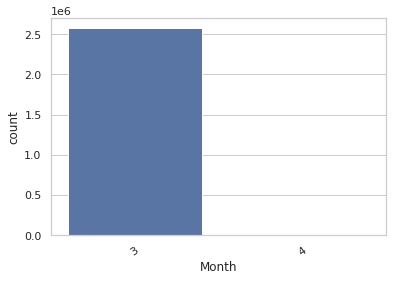

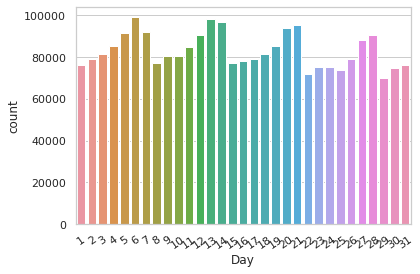

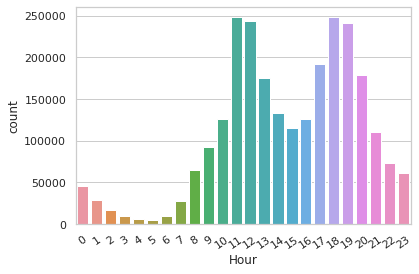

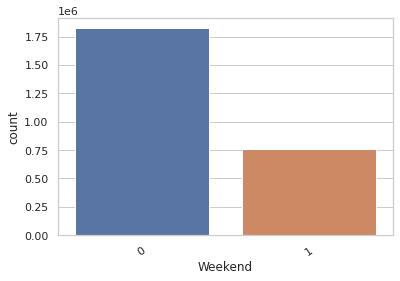

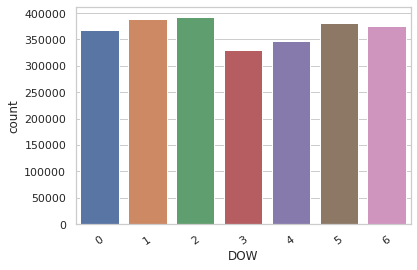

In [32]:
categorical_columns = ['Month','Day','Hour','Weekend','DOW']
for i,c in enumerate(categorical_columns):
    df_cat = cleaned_df[c].value_counts().to_frame().reset_index()
    df_cat.columns = [c,"count"]
    plt.figure(i)
    sns.barplot(df_cat[c],df_cat["count"])
    plt.xticks(rotation=35)
    #plt.figure(figsize = (10,8))
    print(cleaned_df[c].value_counts())
    print("------------------")



*  Most of demands are from the weekend

*   There are three obvious patterns in demand by the created hour: 0am - 5am, 6am-3pm, 4pm-11pm.

*   Most of our data is from March 2021 as given in description and there are very few from April




### Final feature set

In [33]:
cleaned_df.columns

Index(['order_id', 'order_value', 'order_items_count',
       'created_timestamp_local', 'has_instruction',
       'logistics_dropoff_distance', 'has_phone_number',
       'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'class', 'Month',
       'Day', 'Hour', 'DOW', 'Weekend'],
      dtype='object')

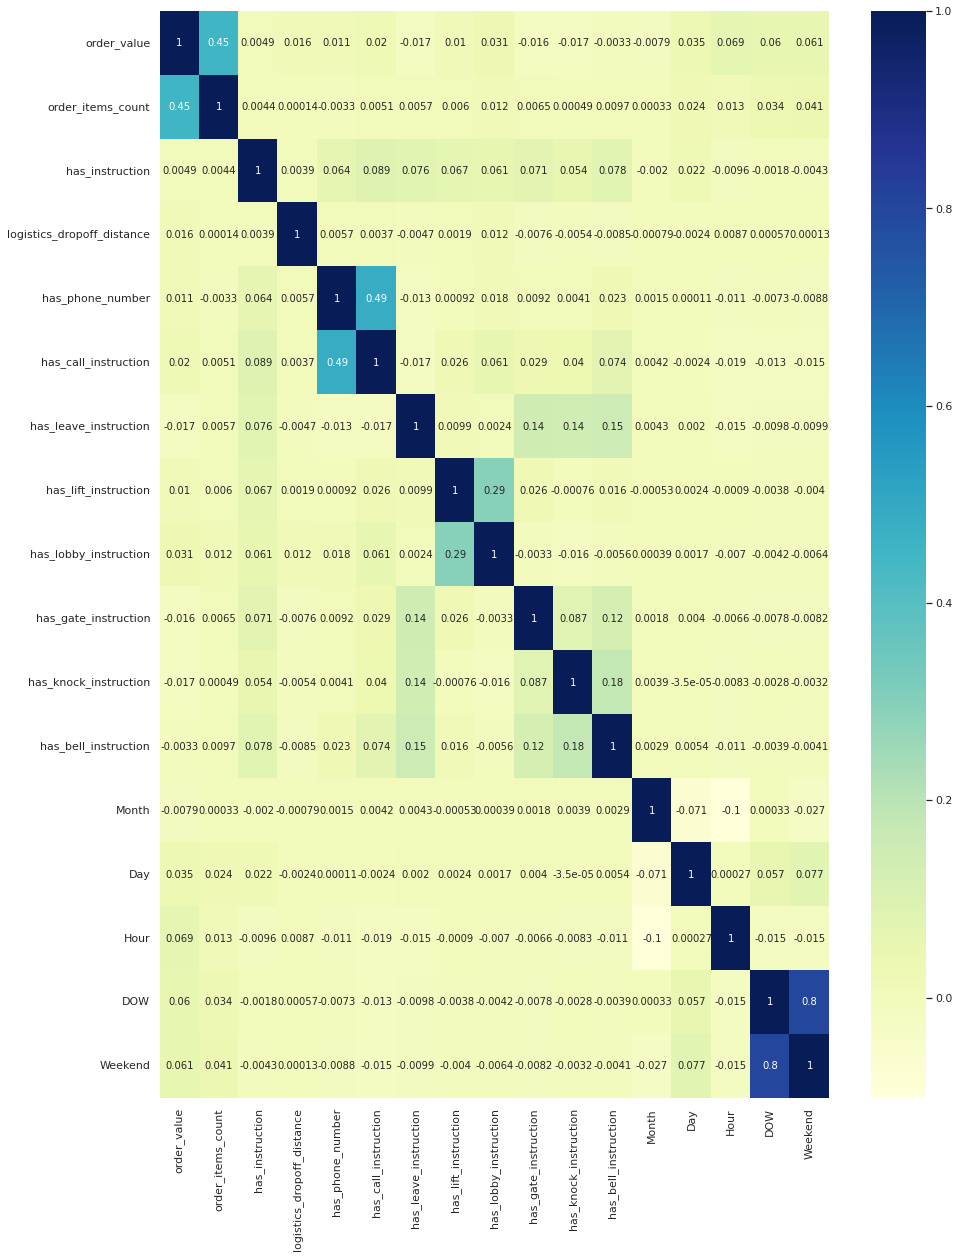

In [34]:

# plotting correlation heatmap
plt.figure(figsize=(15,20))
corrMatrix = cleaned_df.corr()
sns.heatmap(corrMatrix, cmap="YlGnBu", annot=True)  
plt.show()

In [35]:
thresh = 0.8
t1 = corrMatrix.abs()
t1 = t1.unstack()
T = t1.sort_values(kind="quicksort")
print('Features with correlation greater than {}'.format(thresh))
print(T[(T>thresh) & (T<1.0)].drop_duplicates())

Features with correlation greater than 0.8
DOW  Weekend   0.801
dtype: float64


There isn't much correlated variables in pur feature set apart from DOW and weekend

In [36]:
print('Most correlated features to relevance')
print('-'*50)
corrMatrix.abs()['logistics_dropoff_distance'].sort_values(ascending=False)

Most correlated features to relevance
--------------------------------------------------


logistics_dropoff_distance   1.000
order_value                  0.016
has_lobby_instruction        0.012
Hour                         0.009
has_bell_instruction         0.008
has_gate_instruction         0.008
has_phone_number             0.006
has_knock_instruction        0.005
has_leave_instruction        0.005
has_instruction              0.004
has_call_instruction         0.004
Day                          0.002
has_lift_instruction         0.002
Month                        0.001
DOW                          0.001
order_items_count            0.000
Weekend                      0.000
Name: logistics_dropoff_distance, dtype: float64


*  We can eliminate "created_timestamp_local" feature now as we have extracted 
enough features from it 
*   Will remove "Month" as well as the variance is very low




In [37]:

final_df = cleaned_df[['order_id', 'order_value', 'order_items_count',
        'has_instruction','has_phone_number', 'has_call_instruction', 'has_leave_instruction', 'has_lift_instruction',
       'has_lobby_instruction', 'has_gate_instruction','has_knock_instruction', 'has_bell_instruction', 
       'Day', 'Hour', 'DOW', 'Weekend','logistics_dropoff_distance']].reset_index(drop=True)


In [38]:
final_df.head()

,order_id,order_value,order_items_count,has_instruction,has_phone_number,has_call_instruction,has_leave_instruction,has_lift_instruction,has_lobby_instruction,has_gate_instruction,has_knock_instruction,has_bell_instruction,Day,Hour,DOW,Weekend,logistics_dropoff_distance
0,b8ds-tqhf,40,10,1,0,0,0,0,0,0,0,0,11,20,3,0,58
1,x5xx-j2d2,35,10,1,0,0,0,0,0,0,0,0,12,18,4,0,39
2,x6qu-14kt,42,12,1,0,0,1,0,0,0,0,0,27,11,5,1,40
3,x3yw-rhc5,14,11,1,0,0,0,0,0,0,0,0,2,22,1,0,44
4,y9zp-58q7,38,10,1,0,0,0,0,0,0,0,0,23,20,1,0,71


##Modeling

Lets split the dataset as train and test , and keep data from April for testing

In [39]:
final_df.nunique()

order_id                      2580826
order_value                       411
order_items_count                  52
has_instruction                     2
has_phone_number                    2
has_call_instruction                2
has_leave_instruction               2
has_lift_instruction                2
has_lobby_instruction               2
has_gate_instruction                2
has_knock_instruction               2
has_bell_instruction                2
Day                                31
Hour                               24
DOW                                 7
Weekend                             2
logistics_dropoff_distance       1275
dtype: int64

In [40]:
X1 = final_df.drop(['order_id', 'logistics_dropoff_distance'], axis=1)
X= X1.values #returns a numpy array
y = final_df['logistics_dropoff_distance'].values  

In [41]:
X1.columns

Index(['order_value', 'order_items_count', 'has_instruction',
       'has_phone_number', 'has_call_instruction', 'has_leave_instruction',
       'has_lift_instruction', 'has_lobby_instruction', 'has_gate_instruction',
       'has_knock_instruction', 'has_bell_instruction', 'Day', 'Hour', 'DOW',
       'Weekend'],
      dtype='object')

In [42]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30,random_state=5) 

In [43]:
#error display function
def run_error_result(actual,forecast,name):
    def mae(actual,forecast):
        result = 0 
        for a,f in zip(actual,forecast):
            result += abs(a-f)
        return result/len(forecast)

    def mape(actual, forecast): 
        result = 0 
        for a,f in zip(actual,forecast):
                result += abs(a-f)/a
        return result/len(forecast)
    
    def rmse(actual, forecast): 
        rmse = np.sqrt(mean_squared_error(actual, forecast))
        return rmse
    
    return pd.DataFrame({'MAE':[mae(actual, forecast)],'MAPE': [mape(actual,forecast)],'RMSE': [rmse(actual,forecast)]},index=pd.Series([name]))

In [44]:
#%%'Plot feature importance of random forest classifier'
import seaborn as sns
def plot_feature_importance(importance,names,model_type):

    data={'feature_names':names,'feature_importance':importance}
    fi_df = pd.DataFrame(data)
    # train_data = train_data.sort_values(['ST'])
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(['feature_importance'], ascending=False,inplace=True)
    fi_df=fi_df[:31]
    #Define size of bar plot
    plt.figure(figsize=(100,60))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    # plt.savefig(model_type+".JPEG")
    return fi_df

**Model 1 : Linear regression**

In [45]:
#fit LR model
model = LinearRegression().fit(X_train, y_train)    
# get importance
importance = model.coef_
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

# # with statsmodels
# x_train = sm.add_constant(X_train) # adding a constant
# x_test = sm.add_constant(X_test) # adding a constant

# model = sm.OLS(y_train, X_train).fit()
# print(model.summary())
## predict test set  (out-sample)
pred_test = model.predict(X_test)
## predict train set  (in-sample)
pred_train = model.predict(X_train)

print(run_error_result(y_test, pred_test,'test'))
print(run_error_result(y_train, pred_train,'train'))

print("R2 score : %.2f" % r2_score(y_test, pred_test))
print("Mean squared error: %.2f" % mean_squared_error(y_test,y_pred))

# importance = model.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
	print('Feature: %0d, Score: %.5f' % (i,v))

scores = cross_val_score(rf, x_train, y_train, cv = 5)
#
plt.barh(X1.columns, model.feature_importances_)
plt.show()

plt.plot(np.linspace(0,len(y_test), len(y_test)), y_test)
plt.scatter(np.linspace(0,len(y_test), len(y_test)), y_test, color = 'green',label='actual')
plt.scatter(np.linspace(0,len(y_pred), len(y_pred)), y_pred, color = 'red',label='predicted')
plt.legend()
plt.show()

**Model 2 : KNN**

In [ ]:
from sklearn.neighbors import KNeighborsRegressor

knnr = KNeighborsRegressor()
knnr.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = knnr.predict(X_test)
## predict train set  (in-sample)
pred_train = knnr.predict(X_train)

print(run_error_result(y_test, pred_test,'test'))
print(run_error_result(y_train, pred_train,'train'))

# feature_importance=plot_feature_importance(knnr.feature_importances_,X1.columns,'KNN')  

**Model 3 : Random Forest Regressor**


In [1]:
# random forest fit
rf = RandomForestRegressor(n_estimators = 1000)
rf.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = rf.predict(X_test)
## predict train set  (in-sample)
pred_train = rf.predict(X_train)

print(run_error_result(y_test, pred_test,'test'))
print(run_error_result(y_train, pred_train,'train'))
#prepare data for Tree model
feature_importance=plot_feature_importance(rf.feature_importances_,X1.columns,'RF')  



NameError: ignored

**Model 4: Catboost**

In [2]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 119 kB/s 


In [4]:
import catboost as cat
cat_feat = ['Day','Hour','Weekend','DOW']
catr = cat.CatBoostRegressor(random_state=100,cat_features=cat_feat,verbose=0)
catr.fit(X_train, y_train)
## predict test set  (out-sample)
pred_test = catr.predict(X_test)
## predict train set  (in-sample)
pred_train = catr.predict(X_train)

print(run_error_result(y_test, pred_test,'test'))
print(run_error_result(y_train, pred_train,'train'))
#prepare data for Tree model
feature_importance=plot_feature_importance(catr.feature_importances_,X1.columns,'CAT')  

NameError: ignored

**Model 5 : XGBoost**

In [ ]:
import xgboost as xgb
# xgb fit
xgbr = xgb.XGBRegressor(n_estimators = 1000)
xgbr.fit(X_train, y_train)

## predict test set  (out-sample)
pred_test = xgbr.predict(X_test)
## predict train set  (in-sample)
pred_train = xgbr.predict(X_train)

print(run_error_result(y_test, pred_test,'pred_test'))
print(run_error_result(y_train, pred_train,'pred_train'))
#prepare data for Tree model
feature_importance=plot_feature_importance(xgbr.feature_importances_,X1.columns,'XGB')  
